In [1]:
#Import all necessary packages
import numpy as np
import random
import pandas as pd
import os
import json
import gensim
import gensim.downloader
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
import torch
from torch.utils.data import TensorDataset, random_split, Dataset, DataLoader
from torch import nn
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, BertConfig, BertModel
from transformers import get_linear_schedule_with_warmup
from transformers import BertTokenizer
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


import nltk
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [2]:
#Random seed set to my QUB student number
random_seed = 40226944

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU training
    torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior
    torch.backends.cudnn.benchmark = False

set_seed(random_seed)

In [3]:
# Check if we are running in Google Colab

try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    print("This script is running in Google Colab.")
else:
    print("This script is not running in Google Colab.")

if IN_COLAB:
  # Mount the Google Drive
  # If running the notebook on your own local machine you do not need this.

  from google.colab import drive
  drive.mount('/content/drive/')
  home_contents = !ls 'drive/My Drive/'

This script is running in Google Colab.
Mounted at /content/drive/


In [4]:
#cuda GPUS assigned to 'device'. Used later when running BERT model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Section 2.1: Word2Vec

In [5]:
#File directory to story JSON file
fn = '/content/drive/MyDrive/NLP/Coursework/stories.json'

#Open the story fil
with open(fn, 'r') as ifh:
  data = json.load(ifh)

stories = data['stories']
#Finds the total number of stories
total_stories = len(stories)

print(f"Total number of stories is {total_stories}")

Total number of stories is 602


In [6]:
#Download the word2vec model
model = gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [7]:
#Function that retrieves the feature vectors for each story
def get_feature_vectors(text, model):
    tokens = word_tokenize(text) #The text is tokenized

    vector_list = []
    for token in tokens:
        if token in model: #Check if the token (word) can be recognised by the model
            vector_list.append(model.get_vector(token)) #Get the word vector

    return np.mean(vector_list, axis = 0) #All word vectors are averaged

In [8]:
story_feature_vectors = []
for item in tqdm(stories):
    if "story" in item:
        story = item["story"]
        story_feature_vectors.append(get_feature_vectors(story, model)) #Get the feature vectors for each story. These are used for training the model


100%|██████████| 602/602 [00:01<00:00, 311.25it/s]


In [9]:
random.seed(random_seed)

#Iterate through each story to obtain the story settings
setting_list = []
for item in stories:
    if "setting" in item:
        setting_list.append(item["setting"])

#Train-test split the story vectors
X_train, X_test, y_train, y_test = train_test_split(story_feature_vectors, setting_list, test_size = 0.2, random_state=random_seed)


svc_model = LinearSVC() #Using the Linear SVC model
svc_model.fit(X_train, y_train)
y_pred = svc_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy = {np.round(accuracy*100, 2)}")

Accuracy = 84.3


In [10]:
svc_classification_report = classification_report(y_test, y_pred)
print("CLASSIFICATION REPORT for Word2Vec")
print("-"*20)
print(svc_classification_report)

CLASSIFICATION REPORT for Word2Vec
--------------------
                        precision    recall  f1-score   support

   a modern metropolis       0.96      0.83      0.89        29
  ancient civilisation       0.84      0.76      0.80        21
           outer space       0.89      0.94      0.91        33
post-apocalyptic world       0.67      0.78      0.72        18
            small town       0.81      0.85      0.83        20

              accuracy                           0.84       121
             macro avg       0.83      0.83      0.83       121
          weighted avg       0.85      0.84      0.84       121



## Section 2.2: Bert

In [11]:
#Dataframe created from the stories json file for easier manipulation
stories_df = pd.DataFrame(stories)

pre_trained_model_name = 'bert-base-cased'
#Instantiate bert tokenizer model
bert_tokenizer = BertTokenizer.from_pretrained(pre_trained_model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [12]:
max_len = 512
#This loops will tokenize each story and check the length of each and return the maximum
for item in stories:
    if "story" in item:
        story = item["story"]
        input_ids = bert_tokenizer.encode(story, add_special_tokens=True)

        max_len = max(max_len, len(input_ids))

max_len = 512
#Highest length is 815 so maximum length for BERT will be set to 512
print('Max sentence length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (631 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  512


In [13]:
class StoryDataset(Dataset):

  def __init__(self, stories, targets, tokenizer, max_len):
    self.stories = stories  # List of story texts
    self.targets = targets  # Corresponding targets (labels) for each story
    self.tokenizer = tokenizer  # Tokenizer for encoding the stories
    self.max_len = max_len  # Maximum length of the tokenized input sequences

  # This method returns the number of items (stories) in the dataset.
  def __len__(self):
    return len(self.stories)

  # This method retrieves a single item from the dataset by its index
  def __getitem__(self, item):
    story = str(self.stories[item])  # Ensure the story is a string
    target = self.targets[item]  # Get the corresponding target for the story

    #Each token is encoded using .encode_plus which also provides the input masks
    encoding = self.tokenizer.encode_plus(
      story,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length', #Stories shorter than 512 tokens are padded to that length
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True #Stories longer than 512 tokens are truncated to that length
    )

    # Return a dictionary containing the original story text, the encoded input IDs,
    # the attention mask, and the target label, ready for training or evaluation.
    return {
      'story_text': story,
      'input_ids': encoding['input_ids'].flatten(),  # Flatten the tensor for compatibility with model inputs
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)  # Convert the target to a PyTorch tensor
    }


In [14]:
#Stories split into train and test sets, same as for the word2vec model
df_train, df_test = train_test_split(stories_df, test_size=0.2, random_state=random_seed)
#Test set split into validation and final test set
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=random_seed)

In [15]:
label_encoder = LabelEncoder()

stories_df['setting_encoded'] = label_encoder.fit_transform(stories_df['setting'])

# Add an encoded column to each data split using same encoder
df_train['setting_encoded'] = label_encoder.transform(df_train['setting'])
df_val['setting_encoded'] = label_encoder.transform(df_val['setting'])
df_test['setting_encoded'] = label_encoder.transform(df_test['setting'])

In [16]:
#Gets the mapping for the label encoding
le_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(le_name_mapping)

{'a modern metropolis': 0, 'ancient civilisation': 1, 'outer space': 2, 'post-apocalyptic world': 3, 'small town': 4}


In [17]:
#Function to create dataloaders for train, validation and test sets which is mainly used to split data into batches
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = StoryDataset(
    stories=df.story.to_numpy(),
    targets=df.setting_encoded.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [18]:
#Batch size can be 16 but 32 was specified for faster processing
batch_size = 32
#Creation of dataloaders
train_dataloader = create_data_loader(df_train, bert_tokenizer, max_len, batch_size)
val_dataloader = create_data_loader(df_val, bert_tokenizer, max_len, batch_size)
test_dataloader = create_data_loader(df_test, bert_tokenizer, max_len, batch_size)

In [19]:
#Bert model instantiated
set_seed(random_seed)
bert_model = BertModel.from_pretrained(pre_trained_model_name, return_dict=False)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [20]:
class SettingClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SettingClassifier, self).__init__()
    # Model is simply BERT followed by a linear layer:
    self.bert = BertModel.from_pretrained(pre_trained_model_name, return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    # Get the BERT pooled output
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    # BERT output through linear layer:
    output = self.drop(pooled_output)
    return self.out(output)

In [21]:
#Full bert model for classification instantiated. The 5 refers to the 5 different story settings
set_seed(random_seed)
model = SettingClassifier(5)
model = model.to(device)

In [22]:
epochs = 4
#AdamW optimiser used which is a stochastic gradient descent method
optimizer = AdamW(model.parameters(), lr=2.5e-5, correct_bias=False)
total_steps = len(train_dataloader) * epochs
#Scheduler used to change the learning rate during training
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [23]:
# Runction for training the model for one epoch.
def train_epoch(
  model,           # The model to be trained
  data_loader,     # DataLoader that provides batches of the dataset
  loss_fn,         # Loss function to calculate the difference between expected and actual outcomes
  optimizer,       # Optimization algorithm to adjust model parameters based on gradients
  scheduler,       # Learning rate scheduler to adjust the learning rate over epochs
  device,
  n_examples       # Total number of examples in the dataset
):
  # Set the model to training mode (enables dropout, batch normalization)
  model = model.train()

  losses = []  # List to store the loss of each batch
  correct_predictions = 0  # Counter for the number of correct predictions

  # Iterate over each batch in the data loader
  for d in data_loader:
    # Move the batch data to the specified device
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    set_seed(random_seed)
    # Forward pass: find the model outputs with input_ids and attention_mask
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    # Compute the predictions by finding the index of the max logit
    _, preds = torch.max(outputs, dim=1)
    # Calculate the loss between the model outputs and true targets
    loss = loss_fn(outputs, targets)

    # Count correct predictions to calculate accuracy
    correct_predictions += torch.sum(preds == targets)
    # Append the loss of the current batch to the list
    losses.append(loss.item())

    # Backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()
    # Clip gradients to prevent the exploding gradient problem
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    # Perform a single optimization step (parameter update)
    optimizer.step()
    # Update the learning rate
    scheduler.step()
    # Clear the gradients of all optimized variables
    optimizer.zero_grad()

  # Calculate the average accuracy and loss over all examples
  return correct_predictions.double() / n_examples, np.mean(losses)

In [24]:
# Define a function for evaluating the model's performance on a dataset.
def eval_model(
  model,           # The model to be evaluated
  data_loader,     # DataLoader providing batches of the dataset
  loss_fn,         # Loss function to calculate the difference between expected and actual outcomes
  device,
  n_examples       # Total number of examples in the dataset
):
  # Set the model to evaluation mode (disables dropout, batch normalization, etc.)
  model = model.eval()

  losses = []  # List to store the loss of each batch
  correct_predictions = 0  # Counter for the number of correct predictions

  predictions = []
  real_values = []

  # Disable gradient computation to save memory and computation during evaluation
  with torch.no_grad():
    # Iterate over each batch in the data loader
    for d in data_loader:
      # Move the batch data to the specified device
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      set_seed(random_seed)
      # Forward pass: compute the model outputs with input_ids and attention_mask
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      # Compute the predictions by finding the index of the max logit
      _, preds = torch.max(outputs, dim=1)

      # Calculate the loss between the model outputs and true targets
      loss = loss_fn(outputs, targets)

      # Count correct predictions to calculate accuracy
      correct_predictions += torch.sum(preds == targets)
      # Append the loss of the current batch to the list
      losses.append(loss.item())

      predictions.extend(preds)
      real_values.extend(targets)


  predictions = torch.stack(predictions).cpu()
  real_values = torch.stack(real_values).cpu()

  # Calculate the average accuracy and loss over all examples
  return correct_predictions.double() / n_examples, np.mean(losses), predictions, real_values


In [25]:
%%time
#Accuracy and loss for training and validation recording in this dictionary
history = defaultdict(list)
best_accuracy = 0

for epoch in range(epochs):

  print(f'Epoch {epoch + 1}/{epochs}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_dataloader,
    loss_fn,
    optimizer,
    scheduler,
    device,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss, val_preds, val_reals = eval_model(
    model,
    val_dataloader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state_10.bin') # save best model
    best_accuracy = val_acc

Epoch 1/4
----------
Train loss 1.6896306350827217 accuracy 0.18503118503118504
Val   loss 1.6191590428352356 accuracy 0.25

Epoch 2/4
----------
Train loss 1.4799837693572044 accuracy 0.3076923076923077
Val   loss 1.1495246291160583 accuracy 0.4

Epoch 3/4
----------
Train loss 0.7160710729658604 accuracy 0.8066528066528067
Val   loss 0.3262079805135727 accuracy 0.95

Epoch 4/4
----------
Train loss 0.1842191378818825 accuracy 0.9812889812889813
Val   loss 0.1500818207859993 accuracy 0.95

CPU times: user 2min 7s, sys: 1min 4s, total: 3min 12s
Wall time: 3min 15s


In [26]:
#Get the final test accuracy and loss for the trained bert model
test_acc, test_loss, y_preds, y_true = eval_model(
  model,
  test_dataloader,
  loss_fn,
  device,
  len(df_test)
)

print(f'Test loss {test_loss} accuracy {test_acc}')

Test loss 0.1984444484114647 accuracy 0.9508196721311476


In [27]:
print("CLASSIFICATION REPORT for BERT")
print("-"*20)
print(classification_report(y_true, y_preds, target_names = list(label_encoder.classes_)))

CLASSIFICATION REPORT for BERT
--------------------
                        precision    recall  f1-score   support

   a modern metropolis       1.00      1.00      1.00        16
  ancient civilisation       0.85      1.00      0.92        11
           outer space       1.00      1.00      1.00        18
post-apocalyptic world       0.83      0.83      0.83         6
            small town       1.00      0.80      0.89        10

              accuracy                           0.95        61
             macro avg       0.94      0.93      0.93        61
          weighted avg       0.96      0.95      0.95        61



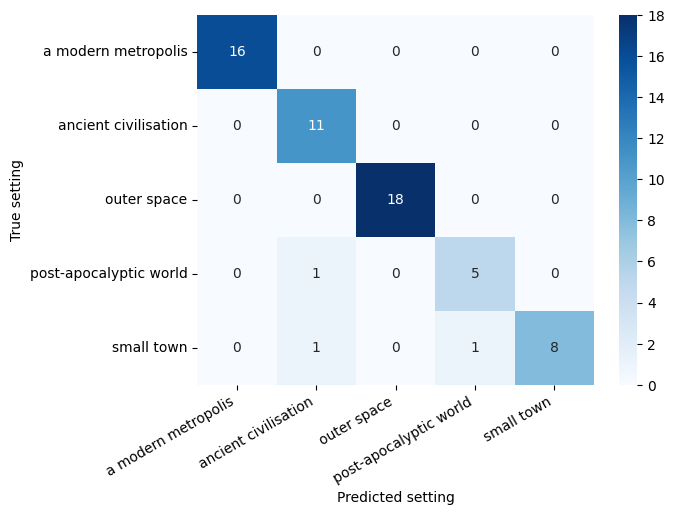

In [28]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True setting')
  plt.xlabel('Predicted setting');

cm_bert = confusion_matrix(y_true, y_preds)
df_cm_bert = pd.DataFrame(cm_bert, index = list(label_encoder.classes_), columns = list(label_encoder.classes_))

show_confusion_matrix(df_cm_bert)